# Dublin Array Data analysis

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *

In [2]:
df = pd.read_csv('data/dublin_bay_vestas_v90_2000.csv', index_col=0, skiprows=3)

In [3]:
df = df[['electricity','wind_speed']]

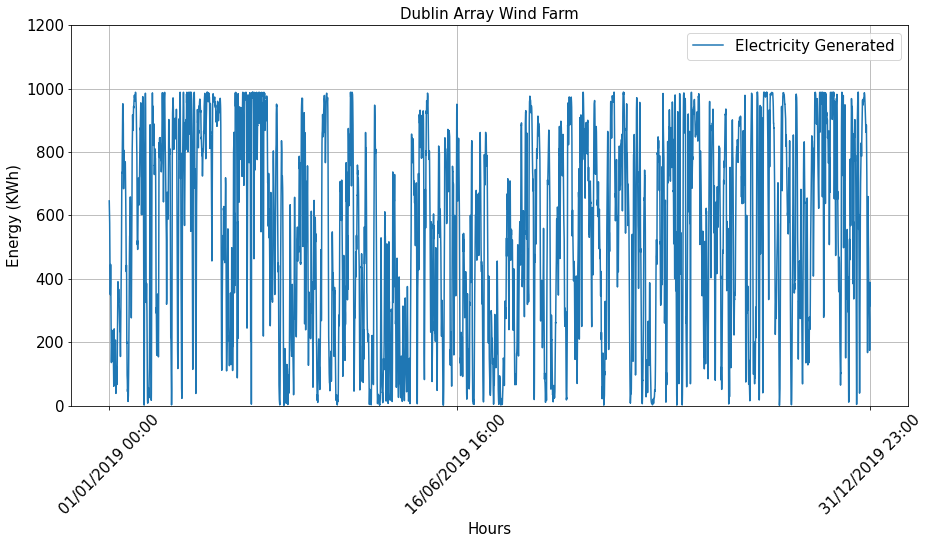

In [4]:
fig,ax = plt.subplots(figsize = [15,7])
#ax.set_title("How long does wind speed need to be measured for?", fontsize = 22, y=1.03)
ax.set_xlabel("Hours", fontsize = 15)
ax.set_ylabel("Energy (KWh)", fontsize = 15)
#ax.set_xlim([0,120])
ax.grid(True)
ax.set_ylim([0,1200])
plt.xticks([0,4000,8759],fontsize= 15, rotation=45)
plt.title('Dublin Array Wind Farm', fontsize=15)
plt.yticks(fontsize= 15)
#plt.plot(df.index, df['IE Solar Generation'], label='Wind Generation')
plt.plot(df.index, df['electricity'], label='Electricity Generated')
plt.legend(fontsize=15)
plt.show()

How to make this a solid output for the year is a good idea? How to do it though is the q

# So this seems to be a working battery discharge model

## Need to get it to work for generation timeseries

Would like to make it so the max amount of power for charging is generation - demand 

In [5]:
df['available'] = df['electricity']-500 #This is just some arbitrary load, can define a different one later

In [6]:
df.index = list(range(1,len(df)+1)) #intuitive index

In [21]:
df.available

1       145.592
2       131.988
3       102.497
4        98.141
5       107.228
         ...   
8756   -254.726
8757   -160.445
8758   -111.302
8759   -126.191
8760   -184.434
Name: available, Length: 8760, dtype: float64

In [15]:
power = 100 #Kwh
hours_of_storage = 10

#Create le model
model = ConcreteModel()

#Everything will be done in timesteps
model.t = Set(initialize=df.index.tolist(), ordered=True)

#Define a few parameters that will model on the constraints
#model.gen = Param(model.t, initialize=df.electricity)
#If this isn't hashed it will grab it anyway?
model.e_available = Param(model.t, initialize=abs(df.available)) 
model.e_capacity = Param(initialize=power*hours_of_storage) #in kWh
model.p_limit = Param(initialize=power)
#put the abs value in here because pyomo kicked up stink otherwise
efficiency = 0.75

#The variables of the problem
model.charge = Var(model.t, domain=NonNegativeReals)
model.e_in = Var(model.t, domain=NonNegativeReals)
model.e_out = Var(model.t, domain=NonNegativeReals)
#model.capacity = Var(domain=NonNegativeReals) not quite ready to make this a variable yet

def state_of_charge(model,t):
    if t == 1:
        return model.charge[t] == 0
    else:
        return model.charge[t] == model.charge[t-1] + model.e_in[t-1] - model.e_out[t-1]
model.soc = Constraint(model.t, rule=state_of_charge)

def capacity_con(model,t):
    return model.charge[t] <= model.e_capacity
model.cap = Constraint(model.t, rule=capacity_con)

def power_con(model,t):
    return model.e_in[t] <= model.p_limit
model.pow = Constraint(model.t, rule=power_con)

def charging_con(model,t):
    return model.e_in[t] <= model.e_available[t]*efficiency
model.con1 = Constraint(model.t, rule=charging_con)

def discharging_con(model,t): #next bits a bit tricky where we try and make it keep track of it's state of charge
    return model.e_out[t] <= model.charge[t]
model.con2 = Constraint(model.t, rule=discharging_con)


profit = sum(model.e_out[t] for t in model.t)
model.obj = Objective(expr=profit, sense=maximize)

# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(model)


In [16]:
#instance.display()
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  result.solver.status)

feasible


In [22]:
value(model.charge[2])

100.0

In [17]:
store = []
for i in range(1,len(df)):
    store.append(value(model.charge[i]))

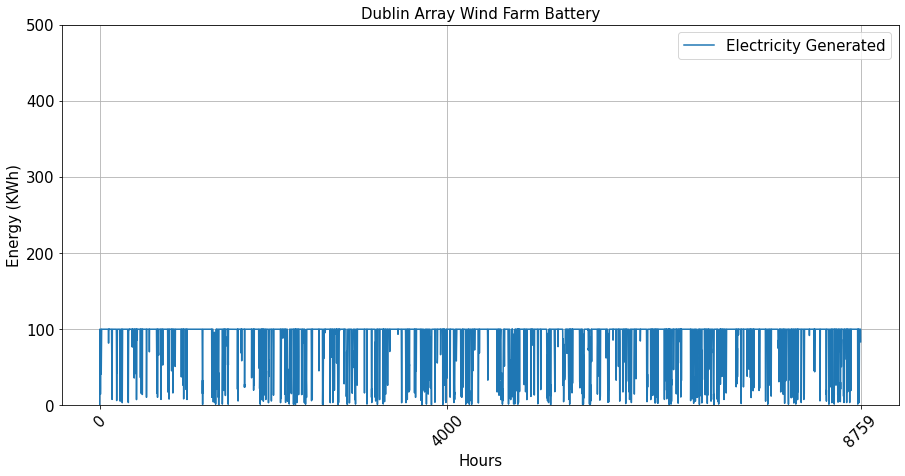

In [20]:
fig,ax = plt.subplots(figsize = [15,7])
#ax.set_title("How long does wind speed need to be measured for?", fontsize = 22, y=1.03)
ax.set_xlabel("Hours", fontsize = 15)
ax.set_ylabel("Energy (KWh)", fontsize = 15)
#ax.set_xlim([0,120])
ax.grid(True)
ax.set_ylim([0,500])
plt.xticks([0,4000,8759],fontsize= 15, rotation=45)
plt.title('Dublin Array Wind Farm Battery', fontsize=15)
plt.yticks(fontsize= 15)
#plt.plot(df.index, df['IE Solar Generation'], label='Wind Generation')
plt.plot(store, label='Electricity Generated')
plt.legend(fontsize=15)
plt.show()

In [119]:
#Filter the data
model = ConcreteModel()

#would like to make it so 
model.T = Set(doc='hour of year', initialize=df.index.tolist(), ordered=True)
model.gen = Param(model.T, initialize=df.electricity)
model.e_available = Param(model.T, initialize=df.available)
model.Rmax = Param(initialize=400,
                   doc='Max rate of power flow (kW) in or out')
model.Smax = Param(initialize=400, doc='Max storage (kWh)')
model.Dmax = Param(initialize=400, doc='Max discharge in 24 hour period')
model.P = Param(initialize=df.electricity.tolist(), doc='LBMP for each hour')
eta = 0.85 # Round trip storage efficiency

# Charge, discharge, and state of charge
# Could use bounds for the first 2 instead of constraints
model.Ein = Var(model.T, domain=NonNegativeReals)
model.Eout = Var(model.T, domain=NonNegativeReals)
model.S = Var(model.T, bounds=(0, model.Smax))

In [120]:
#Set all constraints
def storage_state(model, t):
    'Storage changes with flows in/out and efficiency losses'
    # Set first hour state of charge to half of max
    if t == model.T.first():
        return model.S[t] == model.Smax / 2
    else:
        return (model.S[t] == (model.S[t-1] 
                            + (model.Ein[t-1] * np.sqrt(eta)) 
                            - (model.Eout[t-1] / np.sqrt(eta))))

model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    "Maximum dischage within a single hour"
    return model.Eout[t] <= model.Rmax

model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    "Maximum charge within a single hour"
    return model.Ein[t] <= model.Rmax

model.charge = Constraint(model.T, rule=charge_constraint)

# Without a constraint the model would discharge in the final hour
# even when SOC was 0.
def positive_charge(model, t):
    'Limit discharge to the amount of charge in battery, including losses'
    return model.Eout[t] <= model.S[t] / np.sqrt(eta)
model.positive_charge = Constraint(model.T, rule=positive_charge)

def discharge_limit(model, t):
    "Limit on discharge within a 24 hour period"
    max_t = model.T.last()

    # Check all t until the last 24 hours
    # No need to check with < 24 hours remaining because the constraint is
    # already in place for a larger number of hours
    if t < max_t - 24:
        return sum(model.Eout[i] for i in range(t, t+24)) <= model.Dmax
    else:
        return Constraint.Skip

model.limit_out = Constraint(model.T, rule=discharge_limit)

def demand_constraint(model, t):
    '''The charge of the battery in an hour cannot be greater than this new demand thing'''
    return model.Ein[t] <= model.e_available[t]

model.energy_avail = Constraint(model.T, rule=demand_constraint)
    

# Define the battery income, expenses, and profit
income = sum(df.loc[t, 'electricity'] * model.Eout[t] for t in model.T)
expenses = sum(df.loc[t, 'electricity'] * model.Ein[t] for t in model.T)
profit = income - expenses
model.objective = Objective(expr=profit, sense=maximize)

# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(model)

In [121]:
value(income) #as soon as I try to put something in it breaks

ERROR: evaluating object as numeric value: Eout[1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object Eout[1]
ERROR: evaluating object as numeric value: 645.592*Eout[1] + 631.988*Eout[2] +
    602.497*Eout[3] + 598.141*Eout[4] + 607.228*Eout[5] + 576.367*Eout[6] +
    528.737*Eout[7] + 480.642*Eout[8] + 469.979*Eout[9] + 433.887*Eout[10] +
    394.667*Eout[11] + 359.629*Eout[12] + 349.927*Eout[13] + 365.404*Eout[14]
    + 384.299*Eout[15] + 422.152*Eout[16] + 445.12*Eout[17] + 426.065*Eout[18]
    + 389.073*Eout[19] + 339.506*Eout[20] + 277.77*Eout[21] + 222.223*Eout[22]
    + 182.481*Eout[23] + 155.692*Eout[24] + 140.426*Eout[25] +
    135.788*Eout[26] + 143.162*Eout[27] + 161.841*Eout[28] + 179.071*Eout[29]
    + 197.351*Eout[30] + 218.727*Eout[31] + 234.73*Eout[32] + 237.314*Eout[33]
    + 227.311*Eout[34] + 215.381*Eout[35] + 202.036*Eout[36] +
    186.459*Eout[37] + 168.81*Eout[38] + 153.924*Eout[39] + 142.808*Eout[40

ValueError: No value for uninitialized NumericValue object Eout[1]

In [122]:
#instance.display()
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  result.solver.status)

for i in instance.n:
    print('X[',str(i),']=', round(value(instance.x[i]),2))
print('OF=',round(value(instance.OF),2))

infeasible


AttributeError: 'ConcreteModel' object has no attribute 'n'